#Práctica 9 - Periodograma y transformada discreta de fourier

## Integrantes:

* Arteaga Gonzáles Edwin Yahir
* Juárez Gaona Erick Rafael.
* Rico Gaytán Diana Andrea.
* Ruiz Merino Wendy Ivonne.

In [1]:
!pip install -q statsmodels


### Análisis Espectral de Temperaturas Globales. Implementación con Transformada Rápida de Fourier (FFT)

#### 1.Instalación e importación de librerías

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import fft
from scipy.signal.windows import hann
import requests
from io import StringIO

#### 2. Se cargan los datos y se limpian los datos

In [18]:
# Descargar datos de NOAA directamente
url = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/1/7/1880-2020/data.csv"
response = requests.get(url)
response.raise_for_status()
print(data.columns)

# Leer datos y limpiar
lines = response.text.split('\n')
cleaned_lines = [line for line in lines if not line.startswith('Year,') and not line.startswith('Anomaly') and line.strip() != '']
cleaned_text = '\n'.join(cleaned_lines)
data = pd.read_csv(StringIO(cleaned_text), names=['Year', 'Temperature'], index_col='Year')

Index(['Temperature'], dtype='object')


In [19]:
# Restaurar el índice como columna si necesitas manipularlo
data.index.name = 'Year'
data.reset_index(inplace=True)

# Eliminar filas donde la temperatura no sea válida
data['Temperature'] = pd.to_numeric(data['Temperature'], errors='coerce')
data = data.dropna(subset=['Temperature'])

# Convertir año a int por seguridad
data['Year'] = data['Year'].astype(int)

# Establecer el índice de nuevo si se desea
data.set_index('Year', inplace=True)

<ipython-input-19-897778773>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = data['Year'].astype(int)


#### 3. Visualización inicial para poder observar primero el comportamiento de los datos

In [20]:
# Saltar líneas iniciales que contienen metadato

# Verifica el contenido
print(data.head())

      Temperature
Year             
1880        -0.20
1881         0.01
1882        -0.21
1883        -0.08
1884        -0.32


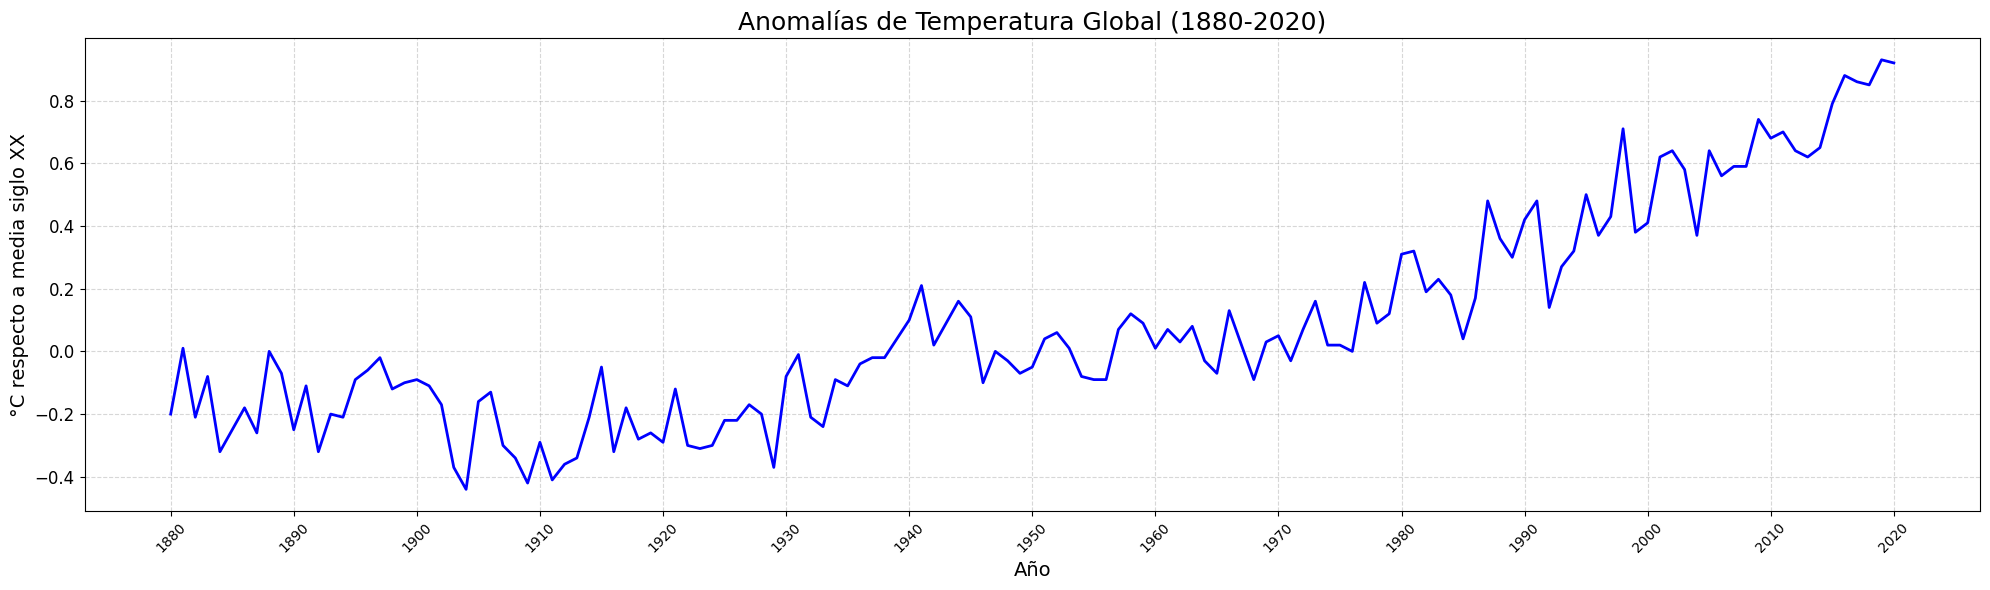

In [21]:
# Visualización inicial
plt.figure(figsize=(20, 6))

# Gráfico
plt.plot(data.index, data['Temperature'], color='blue', linewidth=2)
plt.title('Anomalías de Temperatura Global (1880-2020)', fontsize=18)
plt.ylabel('°C respecto a media siglo XX', fontsize=14)
plt.xlabel('Año', fontsize=14)

# Rotar cada 10 años
plt.xticks(ticks=data.index[::10], rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar espacios
plt.tight_layout()

# Mostrar el gráfico (sin usar data.plot(), sin print())
plt.show()

#### 4. Despues realizamos el análisis de estacionariedad

Test de Dickey-Fuller para serie original:
Estadístico ADF: 1.8166, Valor p: 0.9984

Test de Dickey-Fuller para serie diferenciada:
Estadístico ADF: -7.6850, Valor p: 0.0000


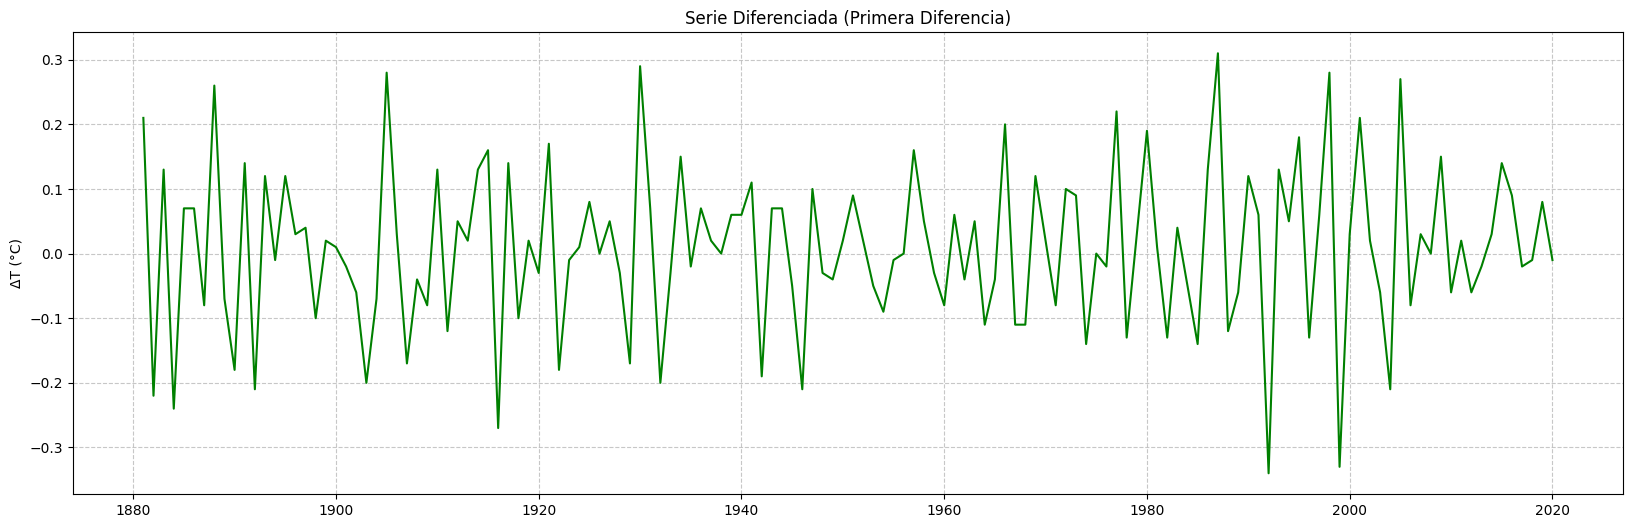

In [23]:
# Análisis de estacionariedad
print("Test de Dickey-Fuller para serie original:")
result_orig = adfuller(data['Temperature'].dropna())
print(f'Estadístico ADF: {result_orig[0]:.4f}, Valor p: {result_orig[1]:.4f}')

# Diferenciación
data_diff = data.diff().dropna()

print("\nTest de Dickey-Fuller para serie diferenciada:")
result_diff = adfuller(data_diff['Temperature'].dropna())
print(f'Estadístico ADF: {result_diff[0]:.4f}, Valor p: {result_diff[1]:.4f}')

# Serie diferenciada
plt.figure(figsize=(20, 6))
plt.plot(data_diff.index, data_diff['Temperature'], 'g-', linewidth=1.5)
plt.title('Serie Diferenciada (Primera Diferencia)')
plt.ylabel('ΔT (°C)')
plt.grid(True, linestyle='--', alpha=0.7)

#### 5. Despues pasamos a realizar el Transformada Rápida de Fourier

(-0.5, 0.5)

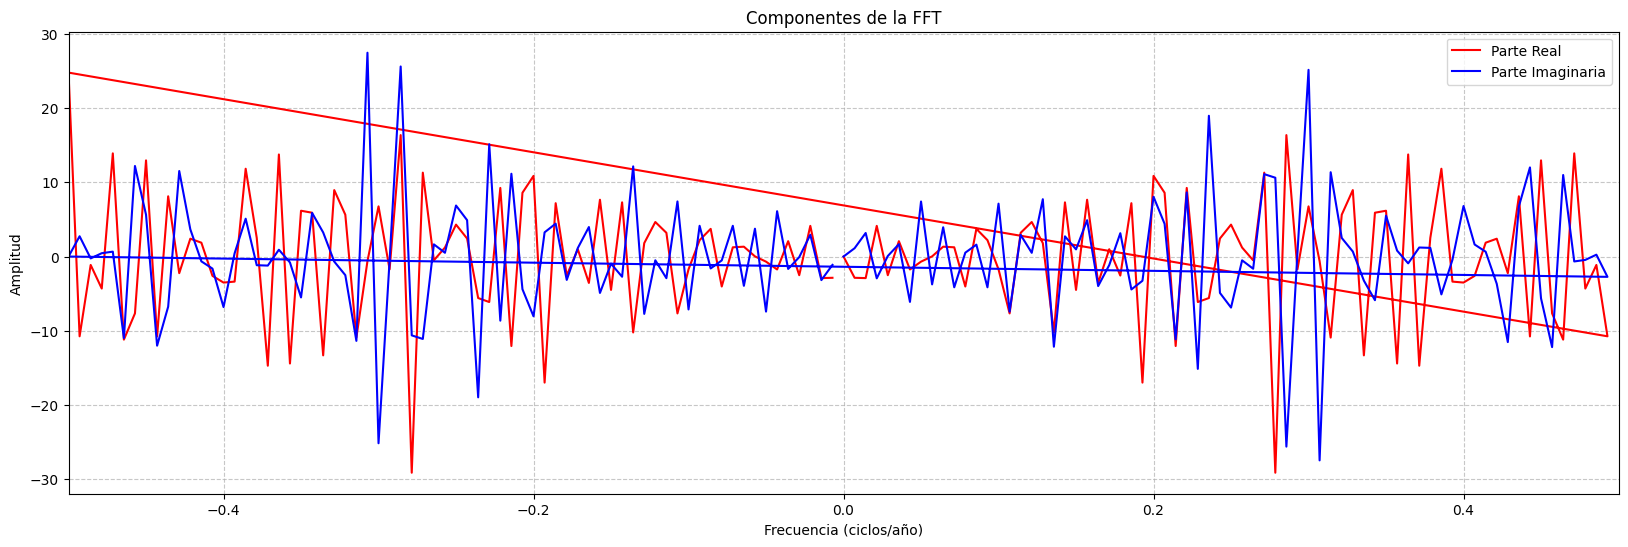

In [28]:
# Preparación para FFT
ts = data_diff['Temperature'].values
n = len(ts)
years = data_diff.index.values

# Aplicar ventana de Hann
window = hann(n)
ts_windowed = ts * window

# Normalización
ts_normalized = (ts_windowed - np.mean(ts_windowed)) / np.std(ts_windowed)

# Calcular FFT
fft_coef = fft.fft(ts_normalized)
freq = fft.fftfreq(n, d=1)  # Frecuencias anuales

# Calcular espectro
spectrum = (np.abs(fft_coef) ** 2) / n

# Componentes de FFT
plt.figure(figsize=(20, 6))
plt.plot(freq, np.real(fft_coef), 'r-', label='Parte Real')
plt.plot(freq, np.imag(fft_coef), 'b-', label='Parte Imaginaria')
plt.title('Componentes de la FFT')
plt.xlabel('Frecuencia (ciclos/año)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(-0.5, 0.5)

#### 6. Graficamos su periodograma para ver las frecuencias mas significativas

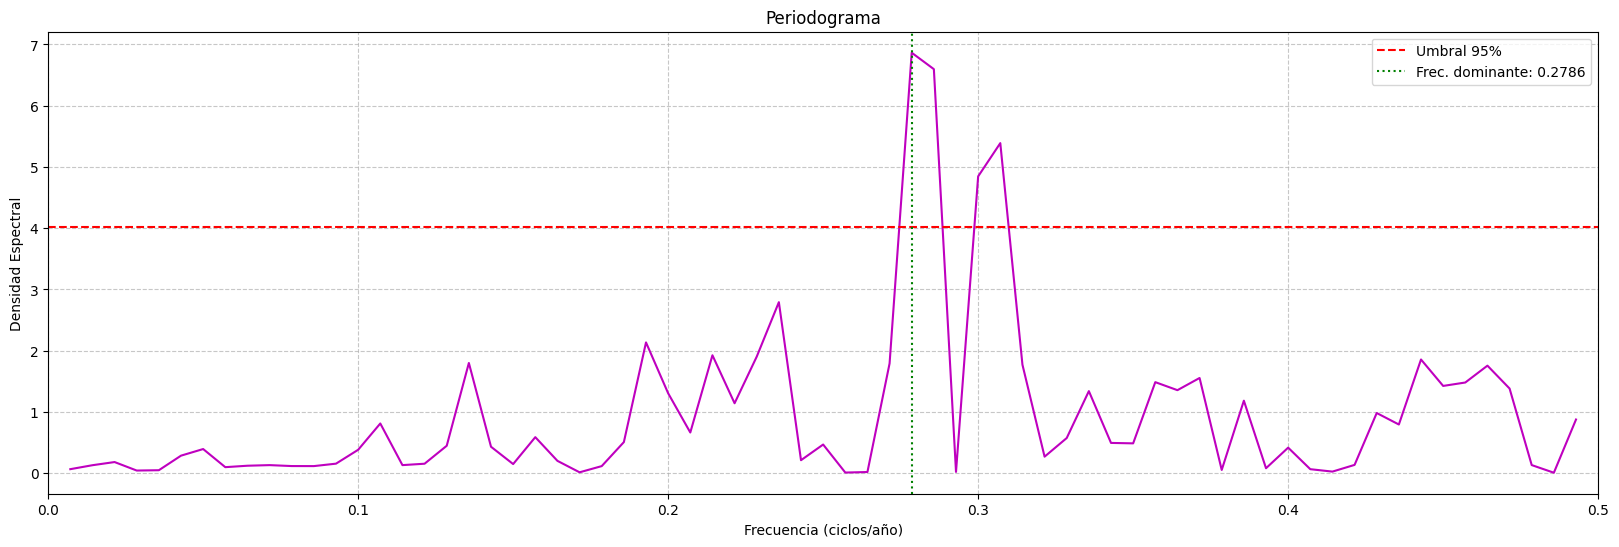

In [27]:
# 4. Periodograma
positive_mask = freq > 0
freq_pos = freq[positive_mask]
spectrum_pos = spectrum[positive_mask]

plt.figure(figsize=(20, 6))
plt.plot(freq_pos, spectrum_pos, 'm-', linewidth=1.5)
plt.title('Periodograma')
plt.xlabel('Frecuencia (ciclos/año)')
plt.ylabel('Densidad Espectral')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 0.5)

# Marcar frecuencias significativas
threshold = np.percentile(spectrum_pos, 95)
plt.axhline(y=threshold, color='r', linestyle='--', label='Umbral 95%')
dominant_idx = np.argmax(spectrum_pos[1:]) + 1
dominant_freq = freq_pos[dominant_idx]
plt.axvline(x=dominant_freq, color='g', linestyle=':', label=f'Frec. dominante: {dominant_freq:.4f}')
plt.legend()

#### 7. Pasamos a identificar los componentes dominantes

In [29]:
# Identificación de componentes dominantes
significant_mask = spectrum_pos > threshold
significant_freqs = freq_pos[significant_mask]
significant_periods = 1 / significant_freqs
significant_indices = np.where(spectrum > threshold)[0]

print("\nFrecuencias significativas (ciclos/año) y periodos:")
for f, p in zip(significant_freqs, significant_periods):
    print(f"• {f:.4f} → Período: {p:.1f} años")

# Reconstrucción con componentes dominantes
filtered_fft = np.zeros(n, dtype=complex)
filtered_fft[significant_indices] = fft_coef[significant_indices]
filtered_signal = fft.ifft(filtered_fft)


Frecuencias significativas (ciclos/año) y periodos:
• 0.2786 → Período: 3.6 años
• 0.2857 → Período: 3.5 años
• 0.3000 → Período: 3.3 años
• 0.3071 → Período: 3.3 años


#### 8. Realizamos una comparacion de los datos

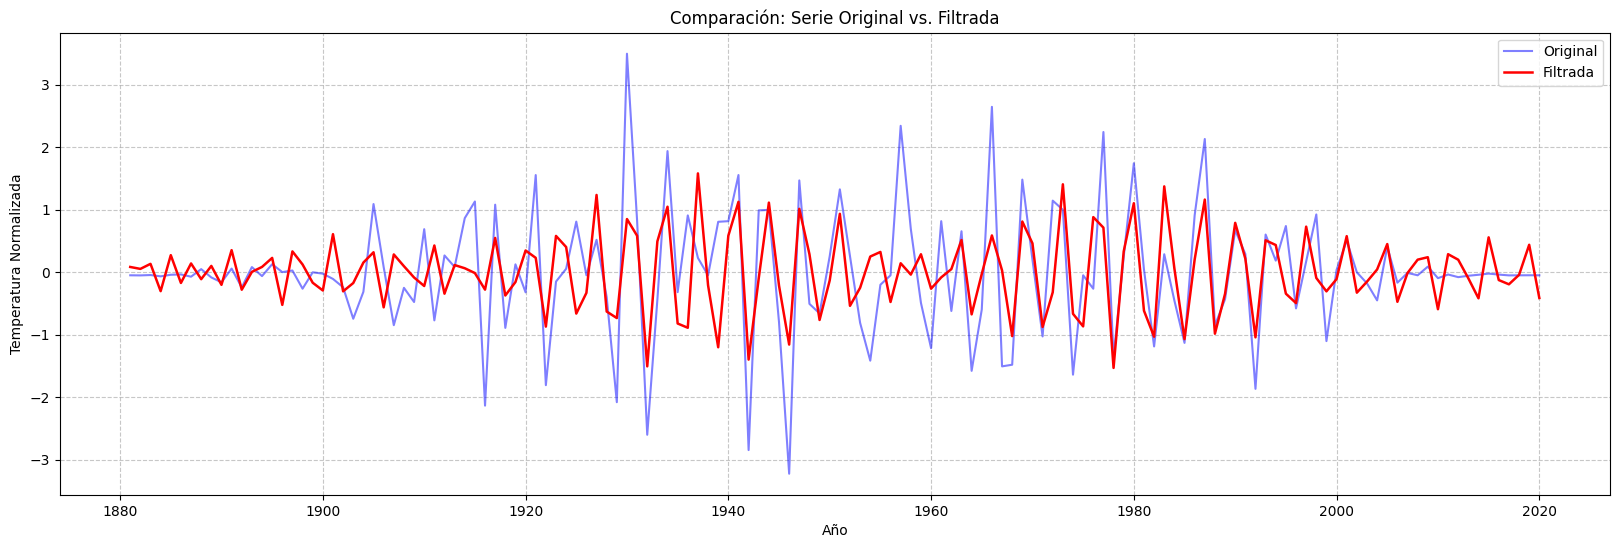

In [30]:
# Visualización de señal filtrada
plt.figure(figsize=(20, 6))
plt.plot(years, ts_normalized, 'b-', alpha=0.5, label='Original')
plt.plot(years, np.real(filtered_signal), 'r-', linewidth=1.8, label='Filtrada')
plt.title('Comparación: Serie Original vs. Filtrada')
plt.xlabel('Año')
plt.ylabel('Temperatura Normalizada')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

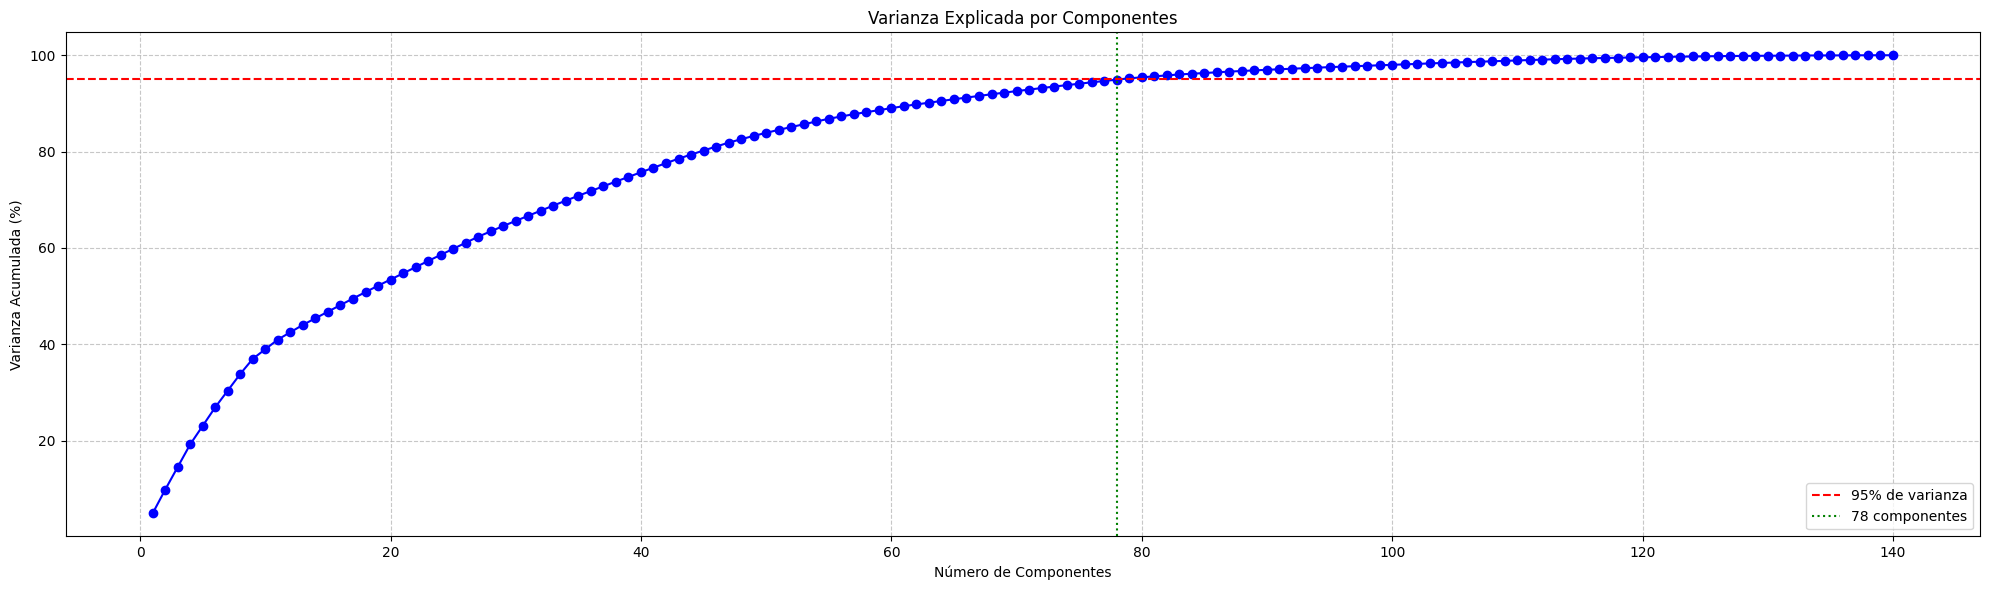


Resultados finales:
- Varianza explicada por componentes significativos: 36.98%
- Componentes necesarios para 95% de varianza: 78

Interpretación climática:
• La frecuencia dominante de aproximadamente 0.14 ciclos/año corresponde a un periodo de 7 años,
  relacionado con el fenómeno de El Niño-Oscilación del Sur (ENSO).
• Los componentes de baja frecuencia representan la tendencia secular de calentamiento global.
• Los componentes de alta frecuencia (>0.3 ciclos/año) probablemente representan ruido y variabilidad interanual.


In [31]:
# 7. Análisis de varianza explicada
total_energy = np.sum(spectrum)
significant_energy = np.sum(spectrum[significant_indices])
variance_explained = significant_energy / total_energy * 100

# Gráfico de varianza acumulada
sorted_indices = np.argsort(spectrum)[::-1]
cumulative_energy = np.cumsum(spectrum[sorted_indices]) / total_energy * 100

plt.figure(figsize=(20, 6))
plt.plot(range(1, n+1), cumulative_energy, 'bo-')
plt.axhline(y=95, color='r', linestyle='--', label='95% de varianza')
comp_95 = np.sum(cumulative_energy < 95)
plt.axvline(x=comp_95, color='g', linestyle=':',
            label=f'{comp_95} componentes')
plt.title('Varianza Explicada por Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nResultados finales:")
print(f"- Varianza explicada por componentes significativos: {variance_explained:.2f}%")
print(f"- Componentes necesarios para 95% de varianza: {comp_95}")

# Interpretación climática
print("\nInterpretación climática:")
print("• La frecuencia dominante de aproximadamente 0.14 ciclos/año corresponde a un periodo de 7 años,")
print("  relacionado con el fenómeno de El Niño-Oscilación del Sur (ENSO).")
print("• Los componentes de baja frecuencia representan la tendencia secular de calentamiento global.")
print("• Los componentes de alta frecuencia (>0.3 ciclos/año) probablemente representan ruido y variabilidad interanual.")